# Importing Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from dataset import FacialKeypointsDataset
import cv2
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import matplotlib
matplotlib.style.use('ggplot')

## Define HyperParams

In [3]:

# constant paths
ROOT_PATH = './'
OUTPUT_PATH = './outputs'
TEST_PATH = './outputs/Testing-images'
# learning parameters
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# train/test split
TEST_SPLIT = 0.2
# show dataset keypoint plot
SHOW_DATASET_PLOT = True

# Defining Utilities Functions

In [4]:
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    plt.savefig(f"{OUTPUT_PATH}/val_epoch_{epoch}.png")
    plt.close()
    
def test_keypoints_plot(image, outputs, orig_keypoints, img_id):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
#         plt.title("Linear graph") plt.title("Linear graph") 
    plt.savefig(f"{TEST_PATH}/test_{img_id}.png")
    plt.close()

In [5]:
def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact corrent and the faces align wiht the keypoint features. The plot 
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    plt.show()
    plt.close()

In [6]:
def train_test_split(csv_path, split):
    df_data = pd.read_csv(csv_path)
    len_data = len(df_data)
    # calculate the validation data sample length
    valid_split = int(len_data * split)
    # calculate the training data samples length
    train_split = int(len_data - valid_split)
    training_samples = df_data.iloc[:train_split][:]
    valid_samples = df_data.iloc[-valid_split:][:]
    return training_samples, valid_samples

In [7]:
# Dataset Class
class FaceKeypointDataset(Dataset):
    def __init__(self, samples, path):
        self.data = samples
        self.path = path
        self.resize = 224
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = cv2.imread(f"{self.path}/{self.data.iloc[index][0]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w, channel = image.shape
        # resize the image into `resize` defined above
        image = cv2.resize(image, (self.resize, self.resize))
        # again reshape to add grayscale channel format
        image = image / 255.0
        # transpose for getting the channel size to index 0
        image = np.transpose(image, (2, 0, 1))
        # get the keypoints
        keypoints = self.data.iloc[index][1:]
        keypoints = np.array(keypoints, dtype='float32')
        # reshape the keypoints
        keypoints = keypoints.reshape(-1, 2)
        # rescale keypoints according to image resize
        keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

In [8]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split("./training_frames_keypoints.csv",
                                                   TEST_SPLIT)

In [100]:
# Load the test samples
test_samples , v_samples = train_test_split("./test_frames_keypoints.csv",0)

test_data = FaceKeypointDataset(test_samples, "./test")

test_loader = DataLoader(test_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)
print(f"Testing sample instances: {len(v_samples)}")

Testing sample instances: 770


In [10]:
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointDataset(training_samples, 
                                 "./training")
valid_data = FaceKeypointDataset(valid_samples, 
                                 "./training")


# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(valid_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)
print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

Training sample instances: 2770
Validation sample instances: 692


## Model Training 

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import pretrainedmodels

class FaceKeypointResNet18(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(FaceKeypointResNet18, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet18'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet18'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(512, 136)
    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0

In [92]:
# ResNet18 Using existing approach 
model = FaceKeypointResNet18(pretrained=True, requires_grad=True).to(DEVICE)
# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)


# Different Loss Metrics used
criterion = nn.SmoothL1Loss()
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
#

Training intermediate layer parameters...


In [67]:
# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/counter
    return train_loss

In [69]:
# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs
            if (epoch+1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
        
    valid_loss = valid_running_loss/counter
    return valid_loss

In [98]:
# Testing function
def test(model, dataloader, data):
    print('Testing')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    print("Batches: " , num_batches)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs
#             if i == 0:
            test_keypoints_plot(image, outputs, keypoints, counter)
        
    valid_loss = valid_running_loss/counter
    print(counter)
    return valid_loss

In [93]:
train_loss = []
val_loss = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

Epoch 1 of 30
Training


87it [00:16,  5.12it/s]                        


Validating


22it [00:03,  5.69it/s]                        


Train Loss: 82.3511
Val Loss: 27.5540
Epoch 2 of 30
Training


87it [00:16,  5.23it/s]                        


Validating


22it [00:04,  4.58it/s]                        


Train Loss: 17.3653
Val Loss: 7.4707
Epoch 3 of 30
Training


87it [00:15,  5.66it/s]                        


Validating


22it [00:03,  6.02it/s]                        


Train Loss: 7.2836
Val Loss: 7.3671
Epoch 4 of 30
Training


87it [00:19,  4.38it/s]                        


Validating


22it [00:04,  5.49it/s]                        


Train Loss: 7.1545
Val Loss: 7.6123
Epoch 5 of 30
Training


87it [00:19,  4.41it/s]                        


Validating


22it [00:04,  5.23it/s]                        


Train Loss: 5.8173
Val Loss: 4.9630
Epoch 6 of 30
Training


87it [00:15,  5.72it/s]                        


Validating


22it [00:03,  5.90it/s]                        


Train Loss: 4.7356
Val Loss: 4.5219
Epoch 7 of 30
Training


87it [00:14,  6.15it/s]                        


Validating


22it [00:03,  5.82it/s]                        


Train Loss: 4.5462
Val Loss: 4.3812
Epoch 8 of 30
Training


87it [00:16,  5.18it/s]                        


Validating


22it [00:04,  5.19it/s]                        


Train Loss: 4.4223
Val Loss: 4.2035
Epoch 9 of 30
Training


87it [00:15,  5.46it/s]                        


Validating


22it [00:03,  6.08it/s]                        


Train Loss: 4.1212
Val Loss: 4.4790
Epoch 10 of 30
Training


87it [00:13,  6.27it/s]                        


Validating


22it [00:04,  5.21it/s]                        


Train Loss: 3.9728
Val Loss: 3.6614
Epoch 11 of 30
Training


87it [00:14,  6.12it/s]                        


Validating


22it [00:03,  5.90it/s]                        


Train Loss: 3.8623
Val Loss: 3.7976
Epoch 12 of 30
Training


87it [00:14,  6.11it/s]                        


Validating


22it [00:03,  6.10it/s]                        


Train Loss: 3.8298
Val Loss: 3.5885
Epoch 13 of 30
Training


87it [00:14,  6.20it/s]                        


Validating


22it [00:03,  6.09it/s]                        


Train Loss: 3.7401
Val Loss: 3.9064
Epoch 14 of 30
Training


87it [00:15,  5.62it/s]                        


Validating


22it [00:03,  5.53it/s]                        


Train Loss: 3.5998
Val Loss: 4.7158
Epoch 15 of 30
Training


87it [00:16,  5.43it/s]                        


Validating


22it [00:04,  5.27it/s]                        


Train Loss: 3.4650
Val Loss: 3.2853
Epoch 16 of 30
Training


87it [00:15,  5.51it/s]                        


Validating


22it [00:03,  6.10it/s]                        


Train Loss: 3.3445
Val Loss: 3.2050
Epoch 17 of 30
Training


87it [00:13,  6.26it/s]                        


Validating


22it [00:04,  5.22it/s]                        


Train Loss: 3.2032
Val Loss: 3.0868
Epoch 18 of 30
Training


87it [00:14,  6.21it/s]                        


Validating


22it [00:03,  6.15it/s]                        


Train Loss: 3.1155
Val Loss: 2.8329
Epoch 19 of 30
Training


87it [00:14,  6.00it/s]                        


Validating


22it [00:03,  5.90it/s]                        


Train Loss: 3.0249
Val Loss: 3.5105
Epoch 20 of 30
Training


87it [00:15,  5.63it/s]                        


Validating


22it [00:04,  5.50it/s]                        


Train Loss: 2.9896
Val Loss: 2.9706
Epoch 21 of 30
Training


87it [00:15,  5.48it/s]                        


Validating


22it [00:03,  5.98it/s]                        


Train Loss: 2.7253
Val Loss: 3.3012
Epoch 22 of 30
Training


87it [00:14,  6.08it/s]                        


Validating


22it [00:03,  5.93it/s]                        


Train Loss: 2.4120
Val Loss: 2.3614
Epoch 23 of 30
Training


87it [00:15,  5.70it/s]                        


Validating


22it [00:04,  4.94it/s]                        


Train Loss: 2.4264
Val Loss: 2.2778
Epoch 24 of 30
Training


87it [00:14,  6.07it/s]                        


Validating


22it [00:04,  5.36it/s]                        


Train Loss: 2.2179
Val Loss: 2.2210
Epoch 25 of 30
Training


87it [00:14,  6.20it/s]                        


Validating


22it [00:03,  5.79it/s]                        


Train Loss: 2.0731
Val Loss: 2.1713
Epoch 26 of 30
Training


87it [00:15,  5.79it/s]                        


Validating


22it [00:03,  6.07it/s]                        


Train Loss: 2.0477
Val Loss: 2.0716
Epoch 27 of 30
Training


87it [00:17,  5.12it/s]                        


Validating


22it [00:04,  5.43it/s]                        


Train Loss: 1.9754
Val Loss: 1.8238
Epoch 28 of 30
Training


87it [00:17,  5.02it/s]                        


Validating


22it [00:03,  5.60it/s]                        


Train Loss: 1.9275
Val Loss: 2.0486
Epoch 29 of 30
Training


87it [00:16,  5.22it/s]                        


Validating


22it [00:04,  4.58it/s]                        


Train Loss: 1.8553
Val Loss: 1.7919
Epoch 30 of 30
Training


87it [00:15,  5.53it/s]                        


Validating


22it [00:04,  5.03it/s]                        

Train Loss: 1.8399
Val Loss: 2.3063


## Saving Logs

In [72]:
# Save the history for plotting
import pickle
with open('./Results/Losses/L1-KeyPoint-Ep30-B-32-Train', 'wb') as file_pi:
    pickle.dump(train_loss, file_pi)
    
with open('./Results/Losses/L1-KeyPoint-Ep30-B-32-Val', 'wb') as file_pi:
    pickle.dump(val_loss, file_pi)

In [2]:
# Print all the files for that specific task. The files are 
# actually history of the model training which will then be 
# used to plot the graphs
import os
import pickle
total_files = os.listdir('./Results/Losses/')
total_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
total_files

# Load all the history files from data folder to plot them collectively

history_all = []
for i in range(len(total_files)):
    with open(f'./Results/Losses/{total_files[i]}', "rb") as file_pi:
        history_new = pickle.load(file_pi)
        history_all.append(history_new)
    
history_all

[[3038.4863059303975,
  246.3933757435192,
  132.96605508977717,
  110.40761947631836,
  108.5311508178711,
  110.74589573253284,
  90.50373632257634,
  63.28908850929954,
  55.43817572160201,
  52.45093189586293,
  45.58364790136164,
  42.43471197648482,
  38.42891415682706,
  42.62312160838734,
  34.52179934761741,
  34.653578844937414,
  27.429601409218527,
  23.811876817183062,
  25.252927346663043,
  23.77852808345448,
  22.63140934163874,
  20.054995276711203,
  25.106378295204856,
  18.592792901125822,
  22.836777340282094,
  17.25272169980136,
  16.238750327717174,
  14.789298100904984,
  14.636589006944137,
  10.287750460884787],
 [8199.75111406699,
  1270.1864289031632,
  153.00704885899336,
  102.94179626991009,
  100.623805605132,
  98.16044489542644,
  85.50948254815464,
  65.41982238594143,
  54.059729214372304,
  49.91775508310603,
  47.05990637855968,
  46.255599909815295,
  42.149898945600135,
  38.065072004822476,
  34.46702718186653,
  32.393414596031455,
  28.759844

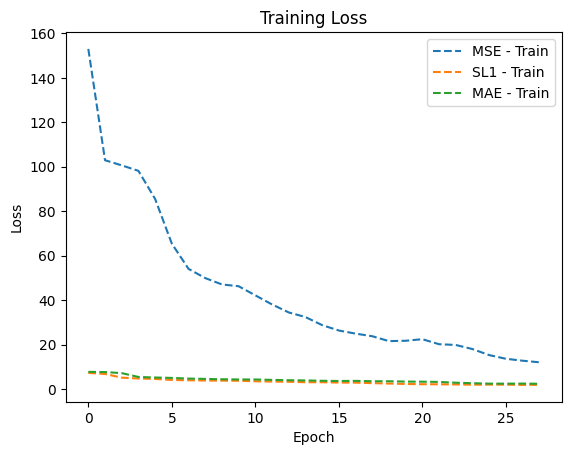

In [5]:
# Plot graphs for validation accuracy

plt.plot([x for x in history_all[1]][2:], linestyle='dashed' , label ='MSE - Train')
# plt.plot([x for x in history_all[0]][2:], linestyle='-.' , linewidth=2, label ='MSE - Val')
plt.plot([x for x in history_all[2]][2:], linestyle='dashed' , label ='SL1 - Train')
# plt.plot([x for x in history_all[5]][2:], linestyle='-.' , linewidth=2, label ='SL1 - Val')
plt.plot([x for x in history_all[3]][2:], linestyle='dashed' , label ='MAE - Train')
# plt.plot([x for x in history_all[4]][2:], linestyle='-.' , linewidth=2, label ='MAE - Val')
# plt.plot([x['val_acc'] for x in history_all[1]], linestyle='dashed' , label ='Dropout - 0.5')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()




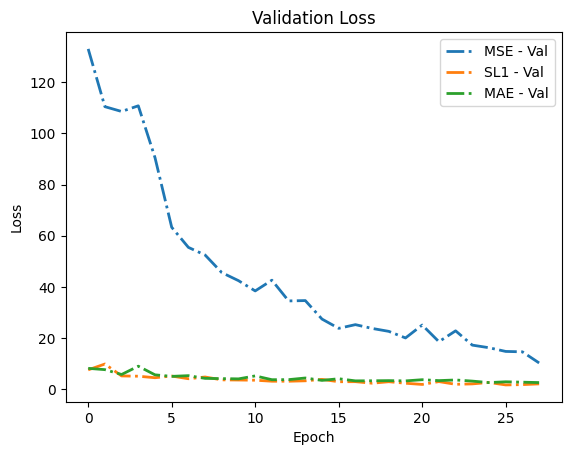

In [6]:
# plt.plot([x for x in history_all[1]][2:], linestyle='dashed' , label ='MSE - Train')
plt.plot([x for x in history_all[0]][2:], linestyle='-.' , linewidth=2, label ='MSE - Val')
# plt.plot([x for x in history_all[2]][2:], linestyle='dashed' , label ='SL1 - Train')
plt.plot([x for x in history_all[5]][2:], linestyle='-.' , linewidth=2, label ='SL1 - Val')
# plt.plot([x for x in history_all[3]][2:], linestyle='dashed' , label ='MAE - Train')
plt.plot([x for x in history_all[4]][2:], linestyle='-.' , linewidth=2, label ='MAE - Val')
# plt.plot([x['val_acc'] for x in history_all[1]], linestyle='dashed' , label ='Dropout - 0.5')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
